<a href="https://colab.research.google.com/github/drwatson93/Stock-Trend-Price-Prediction-Models/blob/main/Stock_Trend_%26_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font size="6">Stock Trend & Price Prediction Models</font></center></h1>


<center><img src="https://miro.medium.com/max/3840/1*opzxrBna63YDbd8_pM5trw.png" height="300" width="1920"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Data Collection - Read Historical Prices</a>  
- <a href='#4'>Data Preparation - Checking the quality of the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
- <a href='#5'>Data exploration - Decomposition</a>
- <a href='#9'>Feature Generation - Technical Indicators</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#61'>Linear Regression</a> 
    - <a href='#62'>k-Nearest Neighbours</a>     
    - <a href='#63'>Long Short Term Memory (LSTM)</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>LightGBM</a> 
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>

# <a id="1">Introduction</a>  
In this notebook I will be using a series of predictive models (RandomForrestClassifier, AdaBoostClassifier, CatBoostClassifier, XGBoost, LightGBM) library to predict future prices of stocks using technical indicator as features. Out of the selected models we will cross validate each and select the best performing. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to articles on Investopedia or the brief description give at the creation of each feature.

To provide linear flow to the notebook we will be using the 7 steps to machine learning deployment.
1. Data Collection.
2. Data Preparation.
3. Choose a Model.
4. Train the Model.
5. Evaluate the Model.
6. Parameter Tuning.
7. Make Predictions.
---


Future: we will develop an app that will provide this information for users via a dashboard.

<left><img src="https://miro.medium.com/max/700/0*V0GyOt3LoDVfY7y5.png" height="100" width="700"></img></left>

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import date
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Importing data from Yahoo Finance.
!pip install yfinance
import yfinance as yf

# to make this notebook's output stable across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
#from warnings import simplefilter
#simplefilter(action='ignore', category=FutureWarning)
#simplefilter(action='ignore', category=DeprecationWarning)

# Change default background color for all visualizations
#layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
#fig = go.Figure(layout=layout)
#templated_fig = pio.to_templated(fig)
#pio.templates['my_template'] = templated_fig.layout.template
#pio.templates.default = 'my_template'

# <a id="2">Data Collection - Read Historical Prices</a>  
I read historical data frame for a chosen stock (e.g. AAPL) which I am going to analyze. New York Stock Exchange dataset gathered from Yahoo Finance provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [ ]:
# loading data from Yahoo Finance.
TICKER = 'BX'
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

def load_data(TICKER, START, TODAY):
    data = yf.download(TICKER, START, TODAY)
    data.reset_index(inplace=True)
    return data

selected_stock_data = load_data(TICKER, START, TODAY)

[*********************100%***********************]  1 of 1 completed


In [ ]:
selected_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,13.25,13.75,13.15,13.71,7.399504,3862700
1,2010-01-05,13.75,13.87,13.62,13.79,7.442681,4072800
2,2010-01-06,13.78,14.09,13.75,14.04,7.577610,4108900
3,2010-01-07,14.04,14.20,13.91,14.09,7.604595,4015200
4,2010-01-08,14.07,14.10,13.87,14.05,7.583009,2830500


# <a id="3">Data Preparation - Checking the quality of the data.</a>  

## <a id="41">Glimpse the data</a>

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day.

An OHLC chart shows the open, high, low and close prices of a stock. It shows you how the price was changing during a particular day and give you a sense of e.g. momentum or volatility of stock. The tip of the lines represent the low and high values and the horizontal segments represent the open and close values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing items are drawn in green whereas decreasing are drawn in red.



In [ ]:
#plot raw data
fig = make_subplots(rows=2, 
                    cols=1,
                    subplot_titles=('{} - Open and Close Price'.format(TICKER), '{} - Volume'.format(TICKER)),             
                    )

fig.add_trace(go.Ohlc(x=selected_stock_data.Date,
                      open=selected_stock_data.Open,
                      high=selected_stock_data.High,
                      low=selected_stock_data.Low,
                      close=selected_stock_data.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Volume, name='Volume'), row=2, col=1)

#fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(
    title='{}'.format(TICKER),
    yaxis_title='{} Stock'.format(TICKER),
    xaxis_title='Year',
    xaxis_rangeslider_visible=False,
    height=900,
    width =1600,
)

fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)

fig.show()

## <a id="42">Check missing data</a>  

In [ ]:
selected_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2845 non-null   datetime64[ns]
 1   Open       2845 non-null   float64       
 2   High       2845 non-null   float64       
 3   Low        2845 non-null   float64       
 4   Close      2845 non-null   float64       
 5   Adj Close  2845 non-null   float64       
 6   Volume     2845 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 155.7 KB


## <a id="5">Data exploration - Decomposition</a>  


<h3>Time Series Components</h3>
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

* **Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.
* **Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

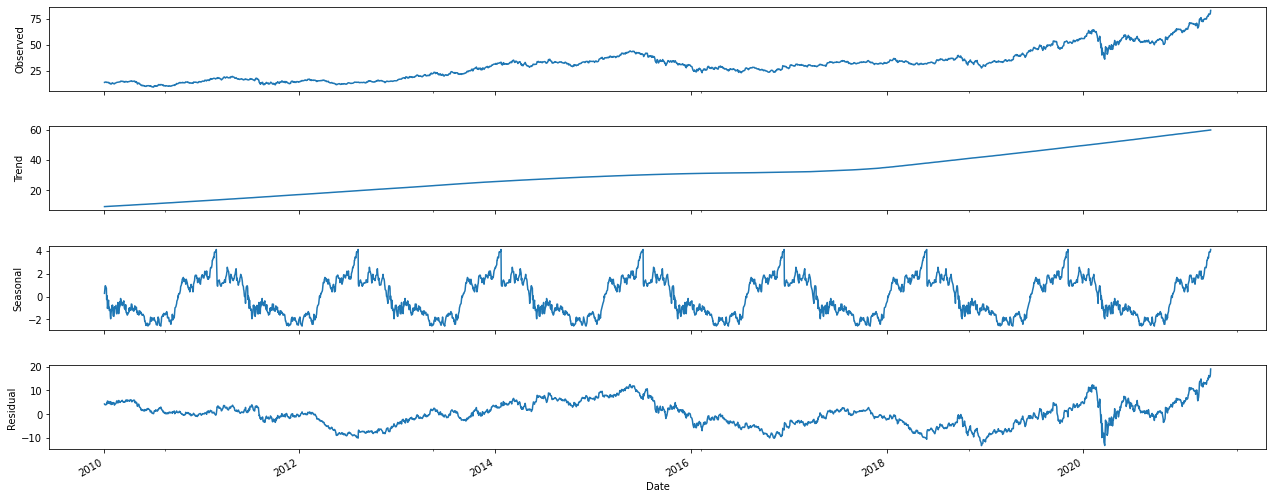

In [ ]:
selected_stock_data_close = selected_stock_data[['Date', 'Close']].copy()
selected_stock_data_close = selected_stock_data_close.set_index('Date')
selected_stock_data_close.head()

decomp = decompose(selected_stock_data_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)


## <a id="9">Feature Generation - Technical Indicators</a>  

**Moving Averages**

I'm calculating few moving averages to be used as features:  **SMA5** ,  **SMA10** ,  **SMA15** ,  **SMA30**  and  **EMA9** .

In [ ]:
selected_stock_data['EMA_9'] = selected_stock_data['Close'].ewm(9).mean().shift()
selected_stock_data['SMA_5'] = selected_stock_data['Close'].rolling(5).mean().shift()
selected_stock_data['SMA_10'] = selected_stock_data['Close'].rolling(10).mean().shift()
selected_stock_data['SMA_15'] = selected_stock_data['Close'].rolling(15).mean().shift()
selected_stock_data['SMA_30'] = selected_stock_data['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close, name='Close', opacity=0.2))
fig.show()

In [ ]:
selected_stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
0,2010-01-04,13.250000,13.750000,13.150000,13.710000,7.399504,3862700,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,13.750000,13.870000,13.620000,13.790000,7.442681,4072800,13.710000,NaN,NaN,NaN,NaN
2,2010-01-06,13.780000,14.090000,13.750000,14.040000,7.577610,4108900,13.752105,NaN,NaN,NaN,NaN
3,2010-01-07,14.040000,14.200000,13.910000,14.090000,7.604595,4015200,13.858339,NaN,NaN,NaN,NaN
4,2010-01-08,14.070000,14.100000,13.870000,14.050000,7.583009,2830500,13.925702,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2840,2021-04-16,79.339996,79.720001,78.790001,79.279999,79.279999,3025700,75.675331,78.062001,76.710001,75.830667,73.911000
2841,2021-04-19,79.330002,79.660004,78.949997,79.300003,79.300003,2425200,76.035797,78.538000,77.119001,76.250001,74.317667
2842,2021-04-20,79.190002,80.000000,78.820000,79.500000,79.500000,2641400,76.362218,78.924001,77.549001,76.582668,74.760334
2843,2021-04-21,79.629997,80.519997,79.500000,80.309998,80.309998,4306400,76.675996,79.146001,78.037001,76.930668,75.159334


**Relative Strength Index**

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [ ]:
def relative_strength_idx(selected_stock_data, n=14):
    close = selected_stock_data['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

selected_stock_data['RSI'] = relative_strength_idx(selected_stock_data).fillna(0)

fig = go.Figure(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.RSI, name='RSI'))
fig.show()

In [ ]:
selected_stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI
0,2010-01-04,13.250000,13.750000,13.150000,13.710000,7.399504,3862700,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,13.750000,13.870000,13.620000,13.790000,7.442681,4072800,13.710000,NaN,NaN,NaN,NaN,0.000000
2,2010-01-06,13.780000,14.090000,13.750000,14.040000,7.577610,4108900,13.752105,NaN,NaN,NaN,NaN,0.000000
3,2010-01-07,14.040000,14.200000,13.910000,14.090000,7.604595,4015200,13.858339,NaN,NaN,NaN,NaN,0.000000
4,2010-01-08,14.070000,14.100000,13.870000,14.050000,7.583009,2830500,13.925702,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,2021-04-16,79.339996,79.720001,78.790001,79.279999,79.279999,3025700,75.675331,78.062001,76.710001,75.830667,73.911000,82.064524
2841,2021-04-19,79.330002,79.660004,78.949997,79.300003,79.300003,2425200,76.035797,78.538000,77.119001,76.250001,74.317667,82.428945
2842,2021-04-20,79.190002,80.000000,78.820000,79.500000,79.500000,2641400,76.362218,78.924001,77.549001,76.582668,74.760334,83.185825
2843,2021-04-21,79.629997,80.519997,79.500000,80.309998,80.309998,4306400,76.675996,79.146001,78.037001,76.930668,75.159334,84.241689


**MACD**

In [ ]:
EMA_12 = pd.Series(selected_stock_data['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(selected_stock_data['Close'].ewm(span=26, min_periods=26).mean())
selected_stock_data['MACD'] = pd.Series(EMA_12 - EMA_26)
selected_stock_data['MACD_signal'] = pd.Series(selected_stock_data.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [ ]:
selected_stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-01-04,13.250000,13.750000,13.150000,13.710000,7.399504,3862700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,13.750000,13.870000,13.620000,13.790000,7.442681,4072800,13.710000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2010-01-06,13.780000,14.090000,13.750000,14.040000,7.577610,4108900,13.752105,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2010-01-07,14.040000,14.200000,13.910000,14.090000,7.604595,4015200,13.858339,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2010-01-08,14.070000,14.100000,13.870000,14.050000,7.583009,2830500,13.925702,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,2021-04-16,79.339996,79.720001,78.790001,79.279999,79.279999,3025700,75.675331,78.062001,76.710001,75.830667,73.911000,82.064524,1.925305,1.624464
2841,2021-04-19,79.330002,79.660004,78.949997,79.300003,79.300003,2425200,76.035797,78.538000,77.119001,76.250001,74.317667,82.428945,1.959154,1.691402
2842,2021-04-20,79.190002,80.000000,78.820000,79.500000,79.500000,2641400,76.362218,78.924001,77.549001,76.582668,74.760334,83.185825,1.979302,1.748982
2843,2021-04-21,79.629997,80.519997,79.500000,80.309998,80.309998,4306400,76.675996,79.146001,78.037001,76.930668,75.159334,84.241689,2.037146,1.806615


**Shift label column**

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [ ]:
selected_stock_data['Close'] = selected_stock_data['Close'].shift(-1)

In [ ]:
selected_stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-01-04,13.250000,13.750000,13.150000,13.790000,7.399504,3862700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,13.750000,13.870000,13.620000,14.040000,7.442681,4072800,13.710000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2010-01-06,13.780000,14.090000,13.750000,14.090000,7.577610,4108900,13.752105,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2010-01-07,14.040000,14.200000,13.910000,14.050000,7.604595,4015200,13.858339,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2010-01-08,14.070000,14.100000,13.870000,14.050000,7.583009,2830500,13.925702,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,2021-04-16,79.339996,79.720001,78.790001,79.300003,79.279999,3025700,75.675331,78.062001,76.710001,75.830667,73.911000,82.064524,1.925305,1.624464
2841,2021-04-19,79.330002,79.660004,78.949997,79.500000,79.300003,2425200,76.035797,78.538000,77.119001,76.250001,74.317667,82.428945,1.959154,1.691402
2842,2021-04-20,79.190002,80.000000,78.820000,80.309998,79.500000,2641400,76.362218,78.924001,77.549001,76.582668,74.760334,83.185825,1.979302,1.748982
2843,2021-04-21,79.629997,80.519997,79.500000,82.959999,80.309998,4306400,76.675996,79.146001,78.037001,76.930668,75.159334,84.241689,2.037146,1.806615


**Drop invalid samples**

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [ ]:
selected_stock_data = selected_stock_data.iloc[33:] # Because of moving averages and MACD line
selected_stock_data = selected_stock_data[:-1]      # Because of shifting close price

selected_stock_data.index = range(len(selected_stock_data))

In [ ]:
selected_stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2010-02-22,13.800000,13.980000,13.450000,13.830000,7.469670,2834500,13.074613,13.348000,12.958000,12.924667,13.160000,64.873418,0.090044,-0.031562
1,2010-02-23,13.850000,14.180000,13.780000,14.000000,7.464269,4706400,13.153341,13.552000,13.071000,13.038667,13.151667,59.124082,0.127806,0.004146
2,2010-02-24,13.940000,14.190000,13.890000,13.920000,7.556023,4082600,13.222745,13.650000,13.206000,13.100667,13.144333,64.157696,0.168656,0.040140
3,2010-02-25,14.060000,14.270000,13.650000,13.980000,7.512847,5281800,13.302261,13.778000,13.336000,13.145333,13.142667,75.210059,0.192634,0.072889
4,2010-02-26,13.920000,14.240000,13.850000,14.110000,7.545228,2752500,13.365314,13.864000,13.484000,13.192667,13.150333,76.131664,0.213732,0.102696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,2021-04-15,78.949997,80.209999,78.360001,79.279999,79.650002,4292100,75.233701,77.482001,76.198001,75.330667,73.575667,88.275897,1.856134,1.549254
2807,2021-04-16,79.339996,79.720001,78.790001,79.300003,79.279999,3025700,75.675331,78.062001,76.710001,75.830667,73.911000,82.064524,1.925305,1.624464
2808,2021-04-19,79.330002,79.660004,78.949997,79.500000,79.300003,2425200,76.035797,78.538000,77.119001,76.250001,74.317667,82.428945,1.959154,1.691402
2809,2021-04-20,79.190002,80.000000,78.820000,80.309998,79.500000,2641400,76.362218,78.924001,77.549001,76.582668,74.760334,83.185825,1.979302,1.748982


## <a id="6">Predictive model - Choosing the right model</a>  

Spliting of data

In [ ]:
#drop_cols = ['Date']
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']

selected_stock_data_final = selected_stock_data.drop(drop_cols, axis=1)

X_stock_train, X_stock_test, y_stock_train, y_stock_test  = train_test_split(selected_stock_data_final, selected_stock_data_final['Close'], test_size=0.10, random_state=RANDOM_STATE, shuffle=False)


In [ ]:
X_stock_train = X_stock_train.drop('Close', axis=1)
X_stock_test = X_stock_test.drop('Close', axis=1)

In [ ]:
X_stock_train

,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,13.074613,13.348,12.958,12.924667,13.160000,64.873418,0.090044,-0.031562
1,13.153341,13.552,13.071,13.038667,13.151667,59.124082,0.127806,0.004146
2,13.222745,13.650,13.206,13.100667,13.144333,64.157696,0.168656,0.040140
3,13.302261,13.778,13.336,13.145333,13.142667,75.210059,0.192634,0.072889
4,13.365314,13.864,13.484,13.192667,13.150333,76.131664,0.213732,0.102696
...,...,...,...,...,...,...,...,...
2524,59.019452,55.126,58.262,59.992000,61.091667,23.503175,-1.401974,-0.481496
2525,58.726507,55.050,57.674,59.457334,60.936000,35.294112,-1.266531,-0.638503
2526,58.663856,55.470,57.208,59.036667,60.833667,34.270005,-1.170709,-0.744944
2527,58.576471,56.370,56.742,58.699333,60.664333,27.874554,-1.379844,-0.871924


In [ ]:
test_size  = 0.10
#valid_size = 0.30

test_split_idx  = int(selected_stock_data.shape[0] * (1-test_size))
#valid_split_idx = int(selected_stock_data.shape[0] * (1-(valid_size+test_size)))

train_df  = selected_stock_data.loc[:test_split_idx].copy()
#valid_df  = selected_stock_data.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = selected_stock_data.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
#fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [ ]:
#train_df = train_df.drop('Date', 1)
#valid_df = valid_df.drop('Date', 1)
#test_df  = test_df.drop('Date', 1)

In [ ]:
# train_df = train_df.drop(drop_cols, 1)
# valid_df = valid_df.drop(drop_cols, 1)
# test_df  = test_df.drop(drop_cols, 1)

In [ ]:
# y_train = train_df['Close'].copy()
# X_train = train_df.drop(['Close'], 1)

#y_valid = valid_df['Close'].copy()
#X_valid = valid_df.drop(['Close'], 1)

#y_test  = test_df['Close'].copy()
#X_test  = test_df.drop(['Close'], 1)

#X_train.info()

# <a id="64">Model - XGBoost</a>  

In [ ]:
%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

parameters = {
    'n_estimators': [100, 250, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [1, 5, 10, 15],
    'gamma': [0.01, 0.05, 0.1, 0.5],
    'objective': ['reg:squarederror']
}

#eval_set = [(X_stock_train, y_stock_train), (X_stock_test, y_stock_test)]
model = xgb.XGBRegressor()
clf = GridSearchCV(estimator = model, 
                   param_grid = parameters, 
                   cv=10,
                   verbose = 1,
                   n_jobs = -1,
                   scoring = 'neg_root_mean_squared_error'
                   )

clf.fit(X_stock_train, y_stock_train)

print('Best params: {}'.format(clf.best_params_))
print('Best validation score = {}'.format(clf.best_score_))

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 59.3min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 63.2min finished


Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 1000, 'objective': 'reg:squarederror'}
Best validation score = -1.8760488911424715
CPU times: user 23.4 s, sys: 1.54 s, total: 24.9 s
Wall time: 1h 3min 10s


In [ ]:
model = xgb.XGBRegressor(**clf.best_params_)
model.fit(X_stock_train, y_stock_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

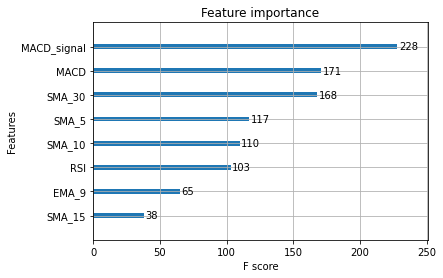

In [ ]:
plot_importance(model);

In [ ]:
y_stock_pred = model.predict(X_stock_test)
print('y_true = {}'.format(np.array(y_stock_test)[:5]))
print('y_pred = {}'.format(y_stock_pred[:5]))

y_true = [47.34999847 40.06000137 46.72000122 40.52999878 41.43999863]
y_pred = [53.40485  53.32932  52.72404  49.698574 48.33916 ]


In [ ]:
print('mean_squared_error = {}'.format(mean_squared_error(y_stock_test, y_stock_pred)))

mean_squared_error = 57.899228639404576


In [ ]:
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_stock_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# <a id="64">Model - Linear Regression</a>

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_stock_train,y_stock_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_stock_pred = model.predict(X_stock_test)
print('y_true = {}'.format(np.array(y_stock_test)[:5]))
print('y_pred = {}'.format(y_stock_pred[:5]))

y_true = [47.34999847 40.06000137 46.72000122 40.52999878 41.43999863]
y_pred = [49.31318852 47.16686862 42.41326417 45.38027801 42.92674661]


In [ ]:
print('mean_squared_error = {}'.format(mean_squared_error(y_stock_test, y_stock_pred)))

mean_squared_error = 2.3037696262735867


In [ ]:
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_stock_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# <a id="64">Model - k-Nearest Neighbor</a>

In [ ]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
#X_stock_train_scaled = scaler.fit_transform(X_stock_train)
#X_stock_train = pd.DataFrame(X_stock_train_scaled)

#X_stock_test_scaled = scaler.fit_transform(X_stock_test)
#X_stock_test = pd.DataFrame(X_stock_test_scaled)

In [ ]:
parameters = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],
}

knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, parameters, cv=5)

model.fit(X_stock_train,y_stock_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
y_stock_pred = model.predict(X_stock_test)
print('y_true = {}'.format(np.array(y_stock_test)[:5]))
print('y_pred = {}'.format(y_stock_pred[:5]))

y_true = [47.34999847 40.06000137 46.72000122 40.52999878 41.43999863]
y_pred = [54.60400009 53.17399979 51.8859993  51.29400024 50.73399963]


In [ ]:
print('mean_squared_error = {}'.format(mean_squared_error(y_stock_test, y_stock_pred)))

mean_squared_error = 35.03957169516548


In [ ]:
predicted_prices = selected_stock_data.loc[test_split_idx:].copy()
predicted_prices['Close'] = y_stock_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=selected_stock_data.Date, y=selected_stock_data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_stock_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# <a id="64">Model - Long Short Term Memory(LSTM)</a>